# Хакатон Лента: разработка алгоритма и интерфейса предсказательной модели 

### Общая задача

Необходимо создать интерфейс и алгоритм прогноза спроса на 14 дней для товаров
собственного производства.  
Гранулярность ТК-SKU-День.  

Прогноз позволит повысить доступность и продажи в ТК, без повышения списаний и
повышение маржинальности. При изготовлении товаров СП сотрудники будут
ориентироваться не на экспертный подход, а на ML прогноз спроса, в соответствии с
которым будут изготавливать продукцию и планировать заказы сырья.

### Задача DS

Разработать пайплайн прогноза спроса товаров категории "Собственное производство" в штуках и построить прогноз на 14 дней в будущее. Ежедневное обновление.  

Финальный результат работы пайплайна - это отчёт/таблица, в которой строим
прогноз спроса по товарам, в каком количестве необходимо их приготовить в каждом ТК,
для повышения доступности товаров на полке, для увеличения продаж, без увеличения
списаний.

Метрики точности: **WAPE** формула def wape(y_true: np.array, y_pred: np.array):
return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true)).

### Описание данных

1) sales_df_train.csv –данные по продажам за скользящий год для обучения.  

Столбцы:
 - st_id – захэшированное id магазина;
 - pr_sku_id – захэшированное id товара;
 - date – дата;
 - pr_sales_type_id – флаг наличия промо;
 - pr_sales_in_units – число проданных товаров всего (промо и без);
 - pr_promo_sales_in_units – число проданных товаров с признаком промо;
 - pr_sales_in_rub – продажи в руб всего (промо и без);
 - pr_promo_sales_in_rub – продажи с признаком промо в руб;

2) pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.  

Столбцы:
 - pr_group_id – захэшированная группа товара;
 - pr_cat_id – захэшированная категория товара;
 - pr_subcat_id – захэшированная подкатегория товара;
 - pr_sku_id – захэшированное id товара;
 - pr_uom_id (маркер, обозначающий продаётся товар на вес или в шт).

3) pr_st.csv – данные по магазинам.  

Столбцы:
 - st_id – захэшированное id магазина;
 - st_city_id – захэшированное id города;
 - st_division_code id – захэшированное id дивизиона;
 - st_type_format_id – id формата магазина;
 - st_type_loc_id – id тип локации/окружения магазина;
 - st_type_size_id – id типа размера магазина;
 - st_is_active – флаг активного магазина на данный момент.

4) sales_submission.csv – пример файла с результатом работы модели прогноза спроса.

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).

Столбцы:
 - st_id – захэшированное id магазина;
 - pr_sku_id – захэшированное id товара;
 - date – дата (день);
 - target – спрос в шт.

### План работы

1. Preprocessing
 - загружаем файлы
 - смотрим что можно использовать для обучения модели, удаляем аномалии
 - объединяем данные
2. EDA
 - выбросы
 - пропуски
 - анализ продаж
 - анализ временных рядов
3. Feature Engineering
4. Feature Selection
5. Modeling
6. Feature Importances

### 1. Preprocessing

In [73]:
# Импорты бибилиотек
import os
import warnings
from joblib import load, dump
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import optuna
import pickle
from datetime import datetime, timedelta
from typing import Dict, Tuple
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from mlforecast import MLForecast
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# Отключим предупреждения
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Константы
RANDOM_STATE = 112233
# Количество дней в тестовой выборке
test_days = 14
# Количество фолдов в cv
n_folds = 5

#### 1.1 Загружаем данные

In [3]:
# Прочитаем файлы 
df = {}
for file in ['sales_df_train', 'pr_df', 'st_df', 'sales_submission']:
    df[file] = pd.read_csv(f'data/{file}.csv')

#### pr_df.csv

In [4]:
# Посмотрим на данные
df['pr_df'].head(10)

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
5,382fcb7b0b5750896a5bef348f19bddc,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,83b5bd3157dca7df5e5e337a7f3143bc,17
6,cff633e270708ced01bc585eb1421667,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
7,1cfd4c9cd7289a63dc2492f2b0200868,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
8,c7e043e0f743476582f79ba27ba3c51f,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
9,f9ee6d53edebe412feb1118b618900c8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17


In [5]:
# Оценим описательные статистики
df['pr_df'].describe(include = 'all')

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
count,2050,2050,2050,2050,2050.000000
unique,2050,9,43,170,NaN
top,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,8feef08314d477a5b68ba18a6d35819d,NaN
freq,1,806,265,72,NaN
mean,NaN,NaN,NaN,NaN,7.017561
std,NaN,NaN,NaN,NaN,7.752371
min,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,17.000000


In [6]:
# Количество товаров, которые проадются штучно
len(df['pr_df'].loc[df['pr_df']['pr_uom_id'] == 1])

1279

In [7]:
# Количество товаров, которые проадются весом
len(df['pr_df'].loc[df['pr_df']['pr_uom_id'] == 17])

771

Всего товаров 2050 в 9 группах - 43 категории и 170 подкатегорий. В столбце pr_uom_id (маркер, обозначающий продаётся товар на вес или в шт) данные разделились таким образом: 1279 товаров в группе 1 и 771 товар в группе 17.

#### st_df.csv

In [8]:
# Посмотрим на данные
df['st_df'].head(20)

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
5,53e19f3dbb211f20b20b45668303c1b6,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,20,1
6,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
7,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
8,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
9,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1


In [9]:
df['st_df'].describe(include = 'all')

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
count,12,12,12,12.000000,12.000000,12.000000,12.000000
unique,12,7,6,NaN,NaN,NaN,NaN
top,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,NaN,NaN,NaN,NaN
freq,1,2,2,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2.333333,1.916667,16.750000,0.833333
std,NaN,NaN,NaN,1.497473,0.996205,7.557356,0.389249
min,NaN,NaN,NaN,1.000000,1.000000,8.000000,0.000000
25%,NaN,NaN,NaN,1.000000,1.000000,12.000000,1.000000
50%,NaN,NaN,NaN,1.500000,1.500000,15.500000,1.000000
75%,NaN,NaN,NaN,4.000000,3.000000,19.250000,1.000000


In [10]:
df['st_df']['st_is_active'].sum()

10

In [11]:
# id неактивных магазинов
df['st_df'].loc[df['st_df']['st_is_active'] == 0, 'st_id']

0     1aa057313c28fa4a40c5bc084b11d276
10    62f91ce9b820a491ee78c108636db089
Name: st_id, dtype: object

12 магазинов в 7 городах. Дивизионов - 6. Форматов магазинов - 3 (1, 2, 4). Типов локации - 3 (1, 2, 3). Типов размера магазина - 6 (8, 12, 19, 20, 28, 32). Активных магазинов - 10. По неактивным магазинам прогноз строить не будем.

#### sales_submission.csv

In [12]:
# Посмотрим на данные
df['sales_submission'].head(10)

,st_id,pr_sku_id,date,target
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0
5,16a5cdae362b8d27a1d8f8c7b78b4330,02713435f3587e2c81d8f6a9016763ea,2023-07-20,0
6,16a5cdae362b8d27a1d8f8c7b78b4330,0448c8afc036bb44c457d7e9edd74c50,2023-07-20,0
7,16a5cdae362b8d27a1d8f8c7b78b4330,050a8120e2a3b8751df8752fcc0323ef,2023-07-20,0
8,16a5cdae362b8d27a1d8f8c7b78b4330,06076bf3c802444ebc7d5619ab64ceb6,2023-07-20,0
9,16a5cdae362b8d27a1d8f8c7b78b4330,064e3a5648fb4a7f911155bd81f87fd2,2023-07-20,0


In [13]:
# Посмотрим на какие даты нужно делать прогноз
df['sales_submission']['date'].unique()

array(['2023-07-20', '2023-07-21', '2023-07-22', '2023-07-24',
       '2023-07-25', '2023-07-26', '2023-07-27', '2023-07-28',
       '2023-07-19', '2023-07-23', '2023-07-29', '2023-07-30',
       '2023-07-31', '2023-08-01'], dtype=object)

In [14]:
# Посчитаем сколько уникальных магазинов в файле
len(df['sales_submission']['st_id'].unique())

8

In [15]:
shops = df['sales_submission']['st_id'].unique()

Это образец файла для заполнения прогнозов обученной моделью. Спрогнозировать спрос нужно на 14 дней за период с 20 июля - 01 августа 2023г. 

#### sales_df_train.csv

In [16]:
# Посмотрим на данные
df['sales_df_train'].head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [17]:
# Видны строки с нулевыми общими продажами, оценим сколько таких
print(f"Строк с нулевым числом проданных товаров {len(df['sales_df_train'].loc[df['sales_df_train']['pr_sales_in_units'] == 0])}")
print(f"Из них строк с нулевыми продажами в руб {len(df['sales_df_train'].loc[(df['sales_df_train']['pr_sales_in_units'] == 0)&(df['sales_df_train']['pr_sales_in_rub'] == 0)])}")
print(f"% строк с нулевым числом проданных товаров {round(len(df['sales_df_train'].loc[df['sales_df_train']['pr_sales_in_units'] == 0])*100/df['sales_df_train'].shape[0], 2)}")

Строк с нулевым числом проданных товаров 66543
Из них строк с нулевыми продажами в руб 454
% строк с нулевым числом проданных товаров 7.54


In [18]:
# Удалим строки для которых число проданных товаров = 0, но при этом столбец продажа в руб отличается от 0
df['sales_df_train'] = df['sales_df_train'].loc[~((df['sales_df_train']['pr_sales_in_units'] == 0)&(df['sales_df_train']['pr_sales_in_rub'] != 0))]

In [19]:
# Переведем столбец date в фомат даты
df['sales_df_train']['date'] = pd.to_datetime(df['sales_df_train']['date'], format='%Y-%m-%d')

In [20]:
# Проверим есть ли строки у которых продажи в руб = 0, а продажи в единицах отличаются от 0
df['sales_df_train'].loc[(df['sales_df_train']['pr_sales_in_rub'] == 0)&(df['sales_df_train']['pr_sales_in_units'] != 0)]

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
30,f7e6c85504ce6e82442c770f7c8606f0,3474f0e025c7deb7e127a35763bc5512,2023-06-06,1,8.0,8.0,0.0,0.0
6313,53e19f3dbb211f20b20b45668303c1b6,ee21c04f96ab30a8b3ca761e57e016ca,2022-11-09,1,1.0,1.0,0.0,0.0
7432,c81e728d9d4c2f636f067f89cc14862c,90252502ab29331e94fd3113f11c58e0,2022-12-27,1,2.0,2.0,0.0,0.0
8153,f7e6c85504ce6e82442c770f7c8606f0,4e3d5c9fab3fc51a4857846fea3d2e57,2022-12-19,1,1.0,1.0,0.0,0.0
8931,f7e6c85504ce6e82442c770f7c8606f0,0f152427918d29bb1081834c1d375a48,2022-10-28,1,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
876801,1ecfb463472ec9115b10c292ef8bc986,525526d5b2169462195c44d49fff4a44,2022-10-22,1,1.0,1.0,0.0,0.0
878163,fa7cdfad1a5aaf8370ebeda47a1ff1c3,27e8978c9e8b7146c462feb7d24f5637,2022-10-27,1,9.0,9.0,0.0,0.0
882360,6364d3f0f495b6ab9dcf8d3b5c6e0b01,2dc922d957188fb51dd2bd50ec9b555a,2022-10-29,1,12.0,12.0,0.0,0.0
882380,f7e6c85504ce6e82442c770f7c8606f0,9da31b9d3cf407cd724c65b7dfed00ee,2022-11-27,1,3.0,3.0,0.0,0.0


In [21]:
# Удалим такие строки
df['sales_df_train'] = df['sales_df_train'].loc[~((df['sales_df_train']['pr_sales_in_rub'] == 0)&
                                                  (df['sales_df_train']['pr_sales_in_units'] != 0))]

In [22]:
# Сгруппируем данные по каждому магазину

res = df['sales_df_train'].groupby('st_id', as_index=False).agg(
                                            pr_sku_id_count = ('pr_sku_id', 'nunique'),
                                            days_count = ('date', 'nunique'),
                                            date_min = ('date', 'min'),
                                            date_max = ('date', 'max'),
                                            promo_count = ('pr_sales_type_id', 'count')
    
)

res['promo/day'] = round(res['promo_count'] / res['days_count'], 2)
res['promo_count/goods/days'] = round((res['promo_count'] / res['pr_sku_id_count']) / res['days_count'], 2)
res

,st_id,pr_sku_id_count,days_count,date_min,date_max,promo_count,promo/day,promo_count/goods/days
0,084a8a9aa8cced9175bd07bc44998e75,6,31,2023-03-26,2023-06-29,38,1.23,0.20
1,16a5cdae362b8d27a1d8f8c7b78b4330,952,352,2022-08-01,2023-07-18,143980,409.03,0.43
2,1aa057313c28fa4a40c5bc084b11d276,39,31,2022-08-01,2022-08-31,717,23.13,0.59
3,1ecfb463472ec9115b10c292ef8bc986,251,352,2022-08-01,2023-07-18,46200,131.25,0.52
4,42a0e188f5033bc65bf8d78622277c4e,1016,352,2022-08-01,2023-07-18,128557,365.22,0.36
5,53e19f3dbb211f20b20b45668303c1b6,111,352,2022-08-01,2023-07-18,9008,25.59,0.23
6,62f91ce9b820a491ee78c108636db089,2,6,2022-08-24,2022-09-08,10,1.67,0.83
7,6364d3f0f495b6ab9dcf8d3b5c6e0b01,887,352,2022-08-01,2023-07-18,105332,299.24,0.34
8,bd470ca955d9497bbcb808e59952fffc,85,309,2022-08-01,2023-06-23,2495,8.07,0.09
9,c81e728d9d4c2f636f067f89cc14862c,1074,352,2022-08-01,2023-07-18,164784,468.14,0.44


In [23]:
# Количество уникальных товаров по всем магазинам
len(df['sales_df_train']['pr_sku_id'].unique())

1973

В датафрейме содержится информация о продажах 1973 товара в 12 магазинах. Количество проданных товаров варьируется от 2 и 6 (эти магазины возможно закрыты или недавно открыты так для них указана информация только за 6 - 31 дней, всего таких магазинов 3) до 1074. Ассортимент товаров (их количество) скорее всего зависит от размера магазина. Период для большинства магазинов - 352 дня: от 01.08.2022 (10 магазинов из 12) до 18.07.2023 и один магазин 309 дней - до  23.06.2023

Видно, что промо-акции проводятся в среднем от 299 до 468 в день у 6 магазинов, еще 3 магазина предположительно закрылись или недавно открылись и по ним не корректо оценивать, у 3 магазинов количество проводимых акций колеблется от 8 - 131.

In [24]:
# Оставляем для дальнейшего анализа только активные магазины и те, которые есть в sales_submission
df['sales_df_train'] = df['sales_df_train'].loc[df['sales_df_train']['st_id'].isin(shops)]

In [25]:
# Добавим столбец с ценой
df['sales_df_train']['price'] = round(df['sales_df_train']['pr_sales_in_rub'] / df['sales_df_train']['pr_sales_in_units'], 2)

#### 1.2 Объединим данные

Объединим данные по продажам с данными по товарной иерархии и по магазинам.

In [26]:
# Объединяем sales_df_train и st_df
data = df['sales_df_train'].merge(df['st_df'], how='left', on='st_id')
data.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,price,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,165.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,49.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,78.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
3,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,161.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
4,42a0e188f5033bc65bf8d78622277c4e,3474f0e025c7deb7e127a35763bc5512,2022-11-03,0,3.0,0.0,123.0,0.0,41.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1


In [27]:
# Удаляем ненужные столбцы
data = data.drop('st_is_active', axis = 1)

In [28]:
# Объединяем data и pr_df
data = data.merge(df['pr_df'], how='left', on='pr_sku_id')
data.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,price,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,165.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,49.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,78.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17
3,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,161.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1
4,42a0e188f5033bc65bf8d78622277c4e,3474f0e025c7deb7e127a35763bc5512,2022-11-03,0,3.0,0.0,123.0,0.0,41.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17


In [29]:
# Сортируем по магазину, товару и по дате
data = data.sort_values(['st_id', 'pr_sku_id', 'date'])
data.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,price,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
291199,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-13,0,1.0,0.0,81.0,0.0,81.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1
370200,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-14,0,2.0,0.0,153.0,0.0,76.5,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1
622217,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-15,0,2.0,0.0,155.0,0.0,77.5,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1
680868,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-16,0,2.0,0.0,156.0,0.0,78.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1
90662,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-18,0,1.0,0.0,80.0,0.0,80.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1


In [30]:
# Проверка на дубликаты
data.duplicated().sum()

0

#### Так как за одну дату могут быть продажи по промо и без - объединим их и добавим столбец с долей продаж по промо

In [31]:
# Добавляем признаки общие продажи а штуках и рублях (промо + без промо)
data['total_sales_in_units'] = data.groupby(['st_id', 'pr_sku_id', 'date'])['pr_sales_in_units'].transform('sum')
data['total_sales_in_rub'] = data.groupby(['st_id', 'pr_sku_id', 'date'])['pr_sales_in_rub'].transform('sum')
# Вспомагательный признак для расчета доли продаж по промо - суммарные продажи по промо
data['total_sales_in_rub_promo'] = data.groupby(['st_id', 'pr_sku_id', 'date'])['pr_promo_sales_in_rub'].transform('sum')
# Средняя цена и доля продаж по промо
data['price_mean'] = round(data['total_sales_in_rub'] / data['total_sales_in_units'], 2)
data['promo_share'] = round(data['total_sales_in_rub_promo'] / data['total_sales_in_rub'], 2)
data.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,price,st_city_id,...,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,total_sales_in_units,total_sales_in_rub,total_sales_in_rub_promo,price_mean,promo_share
291199,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-13,0,1.0,0.0,81.0,0.0,81.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,1.0,81.0,0.0,81.0,0.0
370200,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-14,0,2.0,0.0,153.0,0.0,76.5,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,2.0,153.0,0.0,76.5,0.0
622217,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-15,0,2.0,0.0,155.0,0.0,77.5,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,2.0,155.0,0.0,77.5,0.0
680868,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-16,0,2.0,0.0,156.0,0.0,78.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,2.0,156.0,0.0,78.0,0.0
90662,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-18,0,1.0,0.0,80.0,0.0,80.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,1.0,80.0,0.0,80.0,0.0


In [32]:
# Удаляем ненужные столбцы и получившиеся дубликаты
data = data.drop(['pr_sales_type_id', 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub',
                 'pr_promo_sales_in_rub', 'price', 'total_sales_in_rub_promo'], axis = 1)
data = data.drop_duplicates()
data.head()

,st_id,pr_sku_id,date,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,total_sales_in_units,total_sales_in_rub,price_mean,promo_share
291199,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-13,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,1.0,81.0,81.0,0.0
370200,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-14,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,2.0,153.0,76.5,0.0
622217,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-15,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,2.0,155.0,77.5,0.0
680868,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-16,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,2.0,156.0,78.0,0.0
90662,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-18,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,1.0,80.0,80.0,0.0


**ВЫВОДЫ ПО ПЕРВОЙ ЧАСТИ**

### 2. EDA

In [33]:
# Оценим описательные статистики
data[['total_sales_in_units', 'total_sales_in_rub', 'price_mean', 'promo_share']].describe()

,total_sales_in_units,total_sales_in_rub,price_mean,promo_share
count,659166.000000,659166.000000,658988.0,658988.000000
mean,6.732137,790.871761,NaN,0.329341
std,16.104627,1849.228587,NaN,0.431446
min,-39.000000,-2068.000000,-inf,-17.500000
25%,2.000000,157.000000,58.0,0.000000
50%,3.000000,331.000000,122.5,0.000000
75%,6.000000,749.000000,197.0,1.000000
max,2362.000000,183265.000000,inf,45.570000


##### В каждом столбце видны аномально большие значения и отрицательные значения, посмотрим на них внимательнее.

In [34]:
# Оценим как много наблюдений в столбце total_sales_in_units имеют значения меньше 0
data.loc[data['total_sales_in_units'] < 0].sort_values('total_sales_in_units', ascending = True).head()

,st_id,pr_sku_id,date,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,total_sales_in_units,total_sales_in_rub,price_mean,promo_share
498951,42a0e188f5033bc65bf8d78622277c4e,7a5ebc8af2689363da125308abe00d7f,2022-12-19,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,89b0107c6d0aca5f15fa7a715f9e06e5,17,-39.0,-1741.0,44.64,1.00
64058,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b7ef3f85be23f591802b735971941c77,2023-05-19,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1,-27.0,-2068.0,76.59,-0.00
226700,c81e728d9d4c2f636f067f89cc14862c,4cbdf8b7992ce95ea95bee76db0c7156,2023-02-21,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,c82ad41dea071d88197835420ab24d04,17,-15.0,-622.0,41.47,0.21
408486,c81e728d9d4c2f636f067f89cc14862c,48879b7e88dfc566582ac21fb3c8151b,2022-12-26,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,3de2334a314a7a72721f1f74a6cb4cee,0f3abfd67959c079e7b3759440e7415c,17,-14.0,-1911.0,136.50,-0.00
291765,42a0e188f5033bc65bf8d78622277c4e,5ca106c323e777ec8b42dbbab099932c,2022-10-21,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17,-7.0,-366.0,52.29,-0.12


После уточнения у заказчика - отрицательные значения (возвраты по продукции) оставляем без изменения.

In [35]:
# Оценим как много наблюдений в столбце price_mean имеют значения inf и почему
data.sort_values('price_mean', ascending = True).head(7)

,st_id,pr_sku_id,date,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,total_sales_in_units,total_sales_in_rub,price_mean,promo_share
173323,16a5cdae362b8d27a1d8f8c7b78b4330,502862e895172c8b1bb580c34a8c3575,2023-06-03,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,6e84696301885ba0a9dc8de6fe45abd0,17,0.0,-2.0,-inf,-17.50
665513,16a5cdae362b8d27a1d8f8c7b78b4330,b067862254b74824193087f2a16c0c79,2023-05-26,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,32bb90e8976aab5298d5da10fe66f21d,f9ab16852d455ce9203da64f4fc7f92d,f24d451b1a893d2b679152e43db2b29d,1,0.0,-565.0,-inf,4.30
140463,c81e728d9d4c2f636f067f89cc14862c,634781c60ee669e92f10c95f55c37b0e,2023-01-11,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,4bc94de7bab27a1c3a9cd3ba68199f55,17,0.0,-27.0,-inf,-8.96
285017,c81e728d9d4c2f636f067f89cc14862c,a5d9e1b0ca160dcfaf18a21928709e48,2023-05-08,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,60787c41b04097dfea76addfccd12243,17,0.0,-305.0,-inf,-0.72
243186,16a5cdae362b8d27a1d8f8c7b78b4330,b5bd9ec2c8ff3cb0c9f606c1a59ec4b9,2022-10-23,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c51ce410c124a10e0db5e4b97fc2af39,2df45244f09369e16ea3f9117ca45157,c8e00869dc0be7bc8f9e699633edc8cc,1,0.0,-395.0,-inf,3.62
611996,c81e728d9d4c2f636f067f89cc14862c,debe9dfcc3e4dbea1c509ffab6bf9f0b,2023-06-06,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,6512bd43d9caa6e02c990b0a82652dca,b59c67bf196a4758191e42f76670ceba,11fb95ff05cc28bb107e4a920c60b6cf,1,1.0,-518.0,-518.00,6.51
142132,16a5cdae362b8d27a1d8f8c7b78b4330,d8c8c2a73e8b2696fd0d18f4953ad2a4,2023-02-11,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,120e4b609af49ff7b17c3b90e7a28435,1,7.0,1.0,0.14,1.00


In [36]:
# Удалим строки у которых total_sales_in_units = 0, а в рублях продажи есть
data = data.loc[~((data['total_sales_in_units'] == 0)&(data['total_sales_in_rub'] != 0))]

In [37]:
# Оценим описательные статистики
data[['total_sales_in_units', 'total_sales_in_rub', 'price_mean', 'promo_share']].describe()

,total_sales_in_units,total_sales_in_rub,price_mean,promo_share
count,659155.000000,659155.000000,658977.000000,658977.000000
mean,6.732250,790.886270,147.044906,0.329358
std,16.104738,1849.240378,129.638142,0.426357
min,-39.000000,-2068.000000,-518.000000,-3.270000
25%,2.000000,157.000000,58.000000,0.000000
50%,3.000000,331.000000,122.500000,0.000000
75%,6.000000,749.000000,197.000000,1.000000
max,2362.000000,183265.000000,4729.000000,6.590000


In [38]:
# Проверим маленькие значения в столбце price_mean
len(data[data['price_mean'] < 5].sort_values('price_mean', ascending = True))

503

In [39]:
# Оценим как много таких товаров
len(data.loc[data['price_mean'] < 5, 'pr_sku_id'].unique())

48

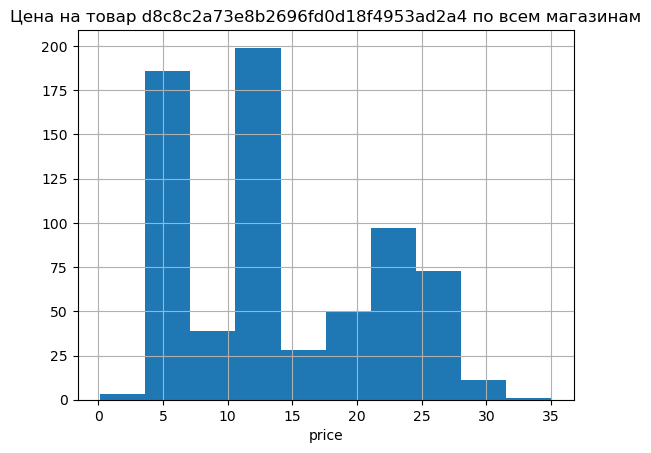

In [40]:
# Для примера распределение по цене для одного товара
df['sales_df_train'].loc[df['sales_df_train']['pr_sku_id'] == 'd8c8c2a73e8b2696fd0d18f4953ad2a4', 'price'].hist()
plt.title('Цена на товар d8c8c2a73e8b2696fd0d18f4953ad2a4 по всем магазинам')
plt.xlabel('price');

У 500 строк в датасете цена ниже 5 руб. Это актуально дл 48 товаров в 33 субкатегориях и 17 категориях.

Возможно, стоит попробовать сделать детекцию аномалий по цене.

In [41]:
# Оценим как много наблюдений в столбце pr_sales_in_units имеют значения более 2000
data.loc[data['total_sales_in_units']>2000]

,st_id,pr_sku_id,date,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,total_sales_in_units,total_sales_in_rub,price_mean,promo_share
191927,fa7cdfad1a5aaf8370ebeda47a1ff1c3,9aa7008fa27151bf77be5f4c9d023d5f,2023-04-15,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,60787c41b04097dfea76addfccd12243,17,2362.0,62863.0,26.61,0.99


Видно единичное значение (один магазин и один товар) продажи по промо 15 апреля 2023г. которого составили 2348 шт. Общая сумма продаж 62 429 руб., соответственно цена за товар - 26.6 руб. 16 апреля 2023г. была пасха, возможно это тематические товары, например, куличи.

In [42]:
# Посмотрим в какие даты продавался данный товар 
dates = df['sales_df_train'].loc[(df['sales_df_train']['pr_sku_id'] == '9aa7008fa27151bf77be5f4c9d023d5f'), 'date'].unique()
dates

array(['2023-04-15T00:00:00.000000000', '2023-04-04T00:00:00.000000000',
       '2023-04-08T00:00:00.000000000', '2023-04-06T00:00:00.000000000',
       '2023-04-24T00:00:00.000000000', '2023-04-07T00:00:00.000000000',
       '2023-04-14T00:00:00.000000000', '2023-04-13T00:00:00.000000000',
       '2023-04-05T00:00:00.000000000', '2023-04-22T00:00:00.000000000',
       '2023-04-10T00:00:00.000000000', '2023-04-16T00:00:00.000000000',
       '2023-04-11T00:00:00.000000000', '2023-04-02T00:00:00.000000000',
       '2023-04-19T00:00:00.000000000', '2023-04-17T00:00:00.000000000',
       '2023-04-01T00:00:00.000000000', '2023-04-09T00:00:00.000000000',
       '2023-03-31T00:00:00.000000000', '2023-04-03T00:00:00.000000000',
       '2023-04-23T00:00:00.000000000', '2023-04-20T00:00:00.000000000',
       '2023-04-12T00:00:00.000000000', '2023-04-18T00:00:00.000000000',
       '2023-04-21T00:00:00.000000000'], dtype='datetime64[ns]')

Видно, что это сезонный товар продавался в период с 31 марта по 24 преля.

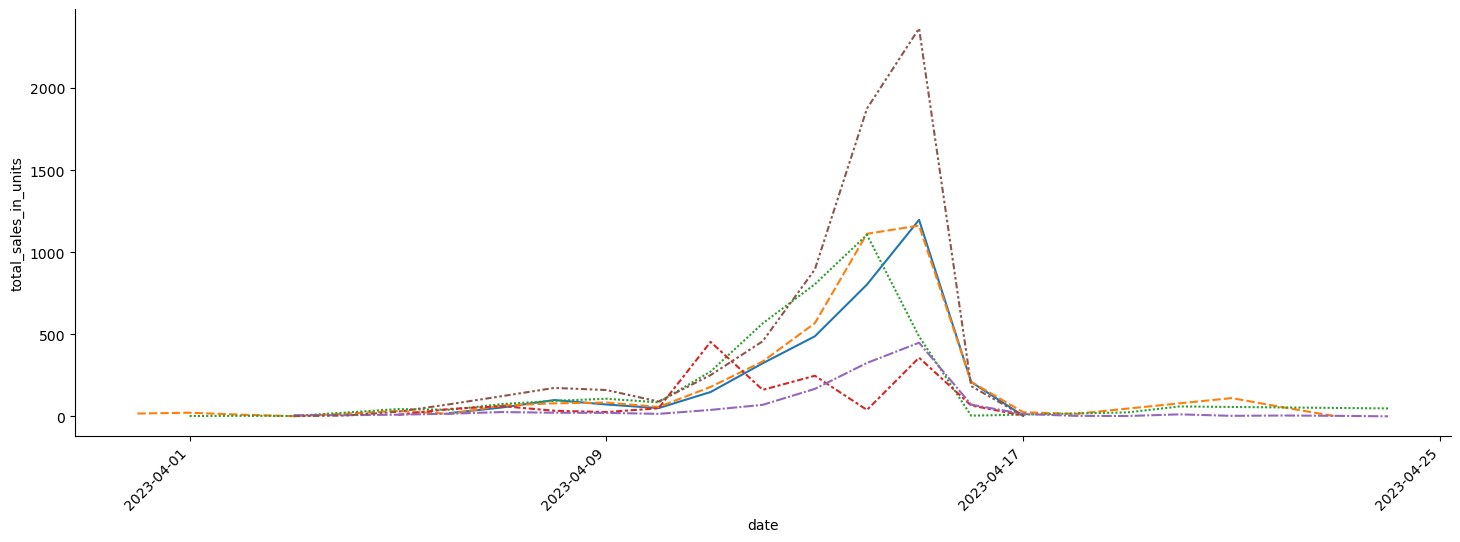

In [43]:
# Построим график продаж данного товара за указанные даты по всем магазинам
g = sns.relplot(
    data=data.loc[(data['pr_sku_id'] ==  '9aa7008fa27151bf77be5f4c9d023d5f')],
    
    x = 'date',
    y= 'total_sales_in_units',
    
    hue = 'st_id',
    style = "st_id",
    
    legend=False,
    kind="line",
    aspect=3,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

Тут видно, что часть магазино имеет пик продаж в ту же дату, но у других магазинов размер пика и дата, на которую он приходится другие. Возможно, это зависит от размера магазина. Попробуем построить аналогичный график, но среди магазинов того же размера.

In [44]:
# Проверим как много магазинов такого же размера продавало этот же товар
data.loc[(data['pr_sku_id'] ==  '9aa7008fa27151bf77be5f4c9d023d5f')&(data['st_type_size_id'] ==  12), 'st_id'].unique()

array(['42a0e188f5033bc65bf8d78622277c4e',
       '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
       'f7e6c85504ce6e82442c770f7c8606f0',
       'fa7cdfad1a5aaf8370ebeda47a1ff1c3'], dtype=object)

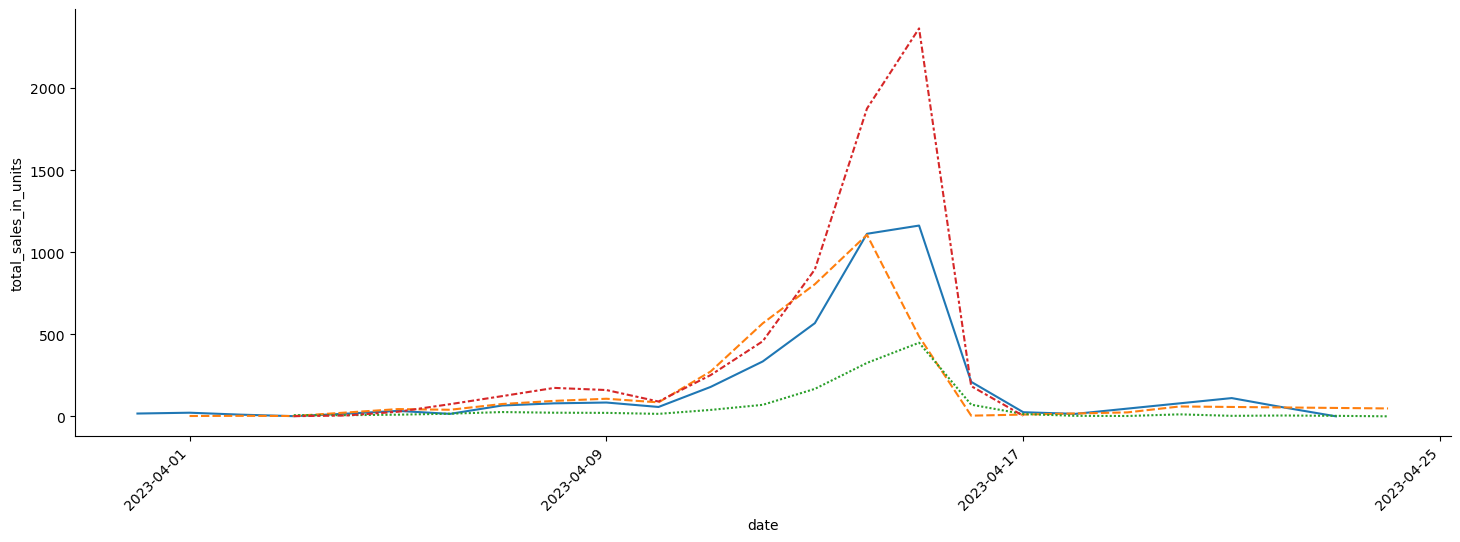

In [45]:
# Построим график продаж данного товара за указанные даты по магазинам такого же размера
g = sns.relplot(
    data = data.loc[(data['pr_sku_id'] ==  '9aa7008fa27151bf77be5f4c9d023d5f')&(data['st_type_size_id'] ==  12)],
    
    x = 'date',
    y= 'total_sales_in_units',
    
    hue = 'st_id',
    style = "st_id",
    
    legend=False,
    kind="line",
    aspect=3,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

Видно, что пиковое значение в два раза превышает среднее значение для своей группы магазинов. 

По остальным магазинам так же видны всплески продаж этого товара в период за неделю до пасхи. Получается в данных есть товары, которые продаются постоянно (весь год) и сезонные.

In [46]:
# Оценим как много наблюдений в столбце pr_sales_in_rub имеют значения более 180 000
data.loc[data['total_sales_in_rub']>180000]

,st_id,pr_sku_id,date,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,total_sales_in_units,total_sales_in_rub,price_mean,promo_share
17575,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,2023-03-21,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1,440.0,183265.0,416.51,1.0


In [47]:
# Посмотрим в какие даты продавался данный товар 
dates = data.loc[(data['pr_sku_id'] == '8cad09283d1d6c5fb08daec8a576a72d'), 'date'].unique()
len(dates)

259

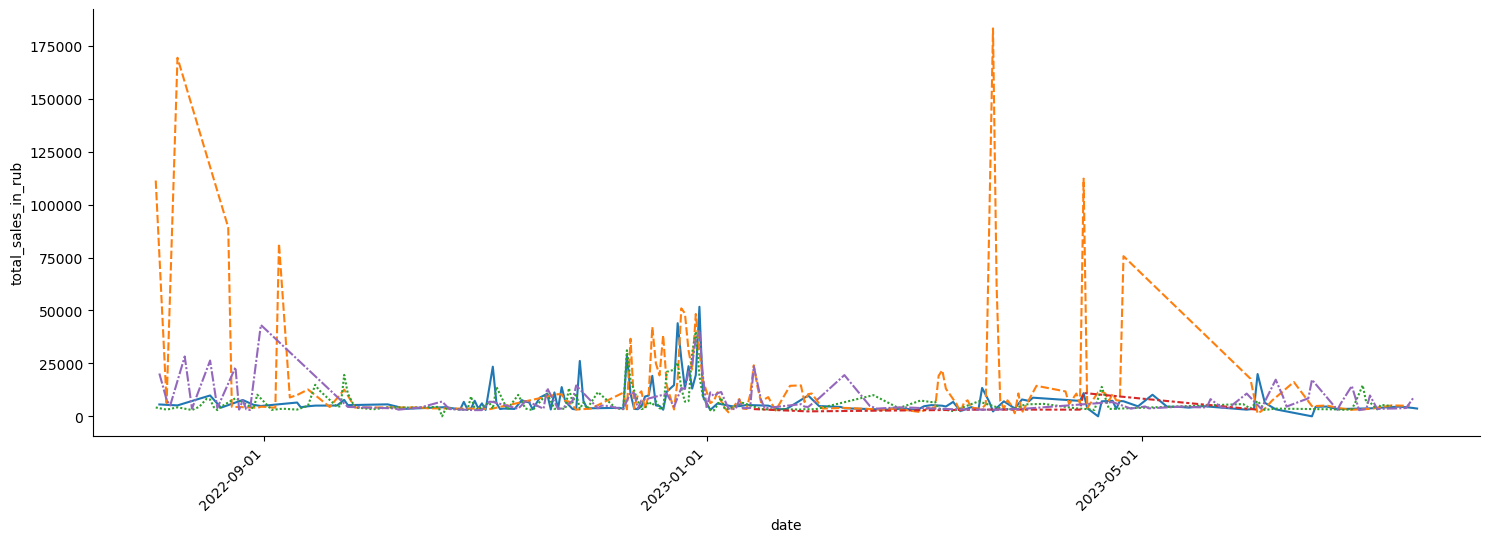

In [48]:
# Посмотрим на продажи этого товара в остальных магазинах
g = sns.relplot(
    data = data.loc[(data['pr_sku_id'] ==  '8cad09283d1d6c5fb08daec8a576a72d')],
    
    x = 'date',
    y= 'total_sales_in_rub',
    
    hue = 'st_id',
    style = "st_id",
    
    legend=False,
    kind="line",
    aspect=3,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

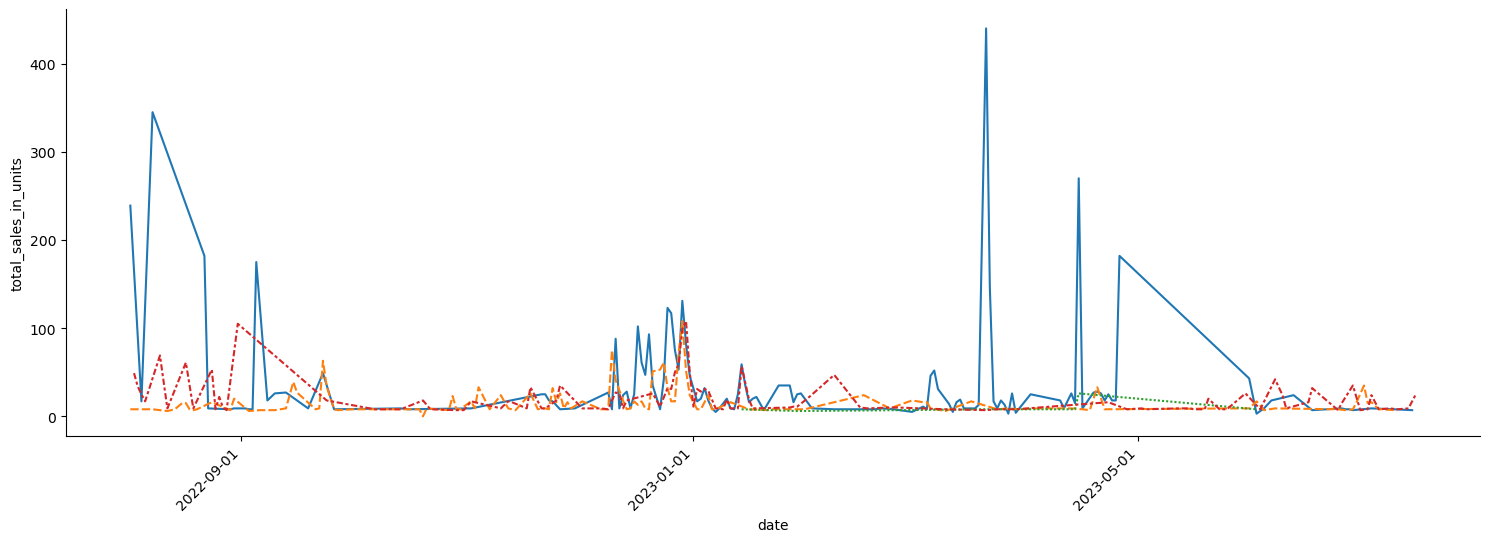

In [49]:
# Построим график продаж данного товара за указанные даты по магазинам такого же размера
g = sns.relplot(
    data = data.loc[(data['pr_sku_id'] ==  '8cad09283d1d6c5fb08daec8a576a72d')&(data['st_type_size_id'] ==  12)],
    
    x = 'date',
    y= 'total_sales_in_units',
    
    hue = 'st_id',
    style = "st_id",
    
    legend=False,
    kind="line",
    aspect=3,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

Видно единичное значение (один магазин и один товар) продажи по промо 21 марта 2023г. которого составили 440 шт. Общая сумма продаж 183 265 руб., соответственно цена за товар - 416.5 руб. 

Этот товар, в отличие от предыдущего, продается круглогодично. Но всплески продаж видны только у одного магазина (синий график). 

Таким образом видно, что в данных имеются выбросы различной природы, которые следует исследовать и исключить для получения качественных прогнозов модели.

#### 2.1 Исследуем пропуски в данных

In [50]:
# Исследуем пропуски по одному товару из одного магазина
res = data.loc[(data['pr_sku_id'] ==  '8cad09283d1d6c5fb08daec8a576a72d')&(data['st_id'] ==  '42a0e188f5033bc65bf8d78622277c4e')]
print(f" Минимальная дата {res['date'].min()}")
print(f" Максимальная дата {res['date'].max()}")
print(f" Количество дней между датами {(res['date'].max()-res['date'].min()).days}")
print(f" Количество дней по которым есть продажи в данных {res['date'].count()}")

 Минимальная дата 2022-08-02 00:00:00
 Максимальная дата 2023-07-14 00:00:00
 Количество дней между датами 346
 Количество дней по которым есть продажи в данных 132


Видно, что в данных есть пропуски и их необходимо заполнить. Внутри периода, по которому есть данные заполним пропуски средним значениям между двумя соседними наблюдениями. За пределами периода - установим значение для продаж равное 0. Последняя дата для каждого наблюдения - 2023-07-18.

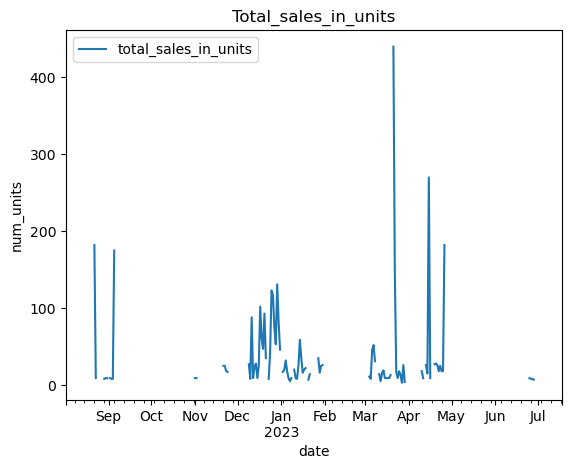

In [51]:
# Посмотрим на данные до заполнения пропусков
res.set_index('date').reindex(pd.date_range(res['date'].min(), '2023-07-18', freq="1D"))[['total_sales_in_units']].plot()
plt.title('Total_sales_in_units')
plt.xlabel('date')  
plt.ylabel('num_units');

In [52]:
# Изменим тип данных для определенных столбцов, так как они категориальные по своей сути
for col in ['st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_uom_id']:
    data[col] = data[col].astype('object')
data[['st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_uom_id']].dtypes

st_type_format_id    object
st_type_loc_id       object
st_type_size_id      object
pr_uom_id            object
dtype: object

In [53]:
# Выделим категориальные столбцы - значения для заполнения по ним известны
cat_columns = data.select_dtypes(include = 'object').columns.to_list()

In [54]:
def filling_blanks(shop, item, cat_columns):
    
    """Возвращает восстановленный временой ряд. Пропуски заполняются при помощи линейной интерполяции.
    Принимает на вход id магазина и товара."""
    # Срез по магазину т товару
    res = data.loc[(data['pr_sku_id'] == item)&(data['st_id'] == shop)]
    
    min_date = res['date'].min()
    max_date = res['date'].max()
    
    # Добавляем пропущенные даты
    res = res.set_index('date').reindex(pd.date_range(min_date, '2023-07-18', freq="1D"))
    
    # Заполняем категориальные столбцы
    for col in cat_columns:
        res[col] = res[col].unique()[0]
    
    # Заполняем пропуски
    res.loc[(res.index > max_date)&(res.index <= '2023-07-18'), 'total_sales_in_units'] = 0
    res['total_sales_in_units'].interpolate(method='time', inplace=True)
    
    return res

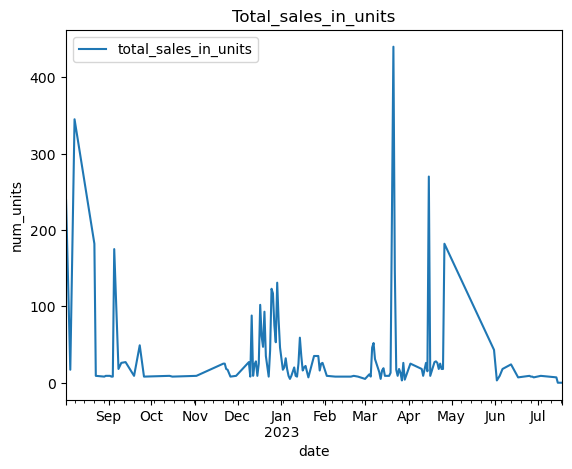

In [55]:
# Посмотрим на пример заполнения пропусков
res =  filling_blanks('42a0e188f5033bc65bf8d78622277c4e', '8cad09283d1d6c5fb08daec8a576a72d', cat_columns)
res[['total_sales_in_units']].plot()
plt.title('Total_sales_in_units')
plt.xlabel('date')  
plt.ylabel('num_units');

In [56]:
# Создаем вспомагательный словарь где ключи - id магазинов, а значения - список с id товаров
shops_items_dict = {}
for shop in data['st_id'].unique():
    items = data.loc[data['st_id'] == shop, 'pr_sku_id'].unique()
    shops_items_dict[shop] = list(items)

In [57]:
def concat_data(shops_items_dict, cat_columns):
    
    """Функция для создания и объединения датафреймов с восстановленными временными рядами."""
    
    data_1 = pd.DataFrame()
    for key, value in shops_items_dict.items():
        data_2 = pd.DataFrame()
        for item in value:
            data_3 = filling_blanks(key, item, cat_columns)
            data_2 = pd.concat([data_2, data_3])
        data_1 = pd.concat([data_1, data_2])                 
    return data_1

In [60]:
flag = True

if flag:
    res = concat_data(shops_items_dict, cat_columns)
    res.to_csv('data/filled_data.csv', index = False)
else:
    res = pd.read_csv('data/filled_data.csv', parse_dates=['date'])

In [61]:
# Посмотрим на размер получившегося датафрейма
res.shape

(1687735, 15)

#### 2.2 Выбросы

In [74]:
def outliers_detection(data, shop, item):
    
    """Функция для детекции выбросов.
    Сравнивает разницу между двумя соседними значениями продаж и заменяет значения, которые преышают 3 сигмы."""
    
    res = data.loc[(data['pr_sku_id'] ==  item)&(data['st_id'] ==  shop)]
    # Рассчет разности
    res['diff'] = res['total_sales_in_units'].diff()
    # Рассчет стандартного отклонения
    std_deviation = np.std(res['diff'])
    three_sigma = 3 * std_deviation
    # Заменяем значение разницы для первого наблюдения (там NaN) на величину продаж за первый день.
    res.loc[res['diff'].isna(), 'diff'] = res.loc[res['diff'].isna(), 'total_sales_in_units']
    # Заменяем выбросы (значения, которые превышают 3 сигмы по разности)
    res.loc[abs(res['diff']) > three_sigma, 'total_sales_in_units'] = three_sigma
    
    return res

In [77]:
ser = outliers_detection(res, '42a0e188f5033bc65bf8d78622277c4e', '8cad09283d1d6c5fb08daec8a576a72d')
ser.head()

,st_id,pr_sku_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,total_sales_in_units,total_sales_in_rub,price_mean,promo_share,diff
2022-08-02,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1,117.041395,111397.0,466.1,1.0,239.000000
2022-08-03,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1,165.000000,NaN,NaN,NaN,-74.000000
2022-08-04,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1,91.000000,NaN,NaN,NaN,-74.000000
2022-08-05,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1,17.000000,6324.0,372.0,1.0,-74.000000
2022-08-06,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1,126.333333,NaN,NaN,NaN,109.333333


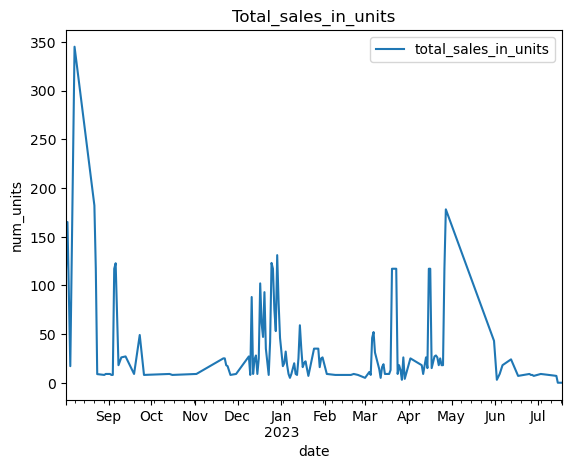

In [78]:
ser[['total_sales_in_units']].plot()
plt.title('Total_sales_in_units')
plt.xlabel('date')  
plt.ylabel('num_units');

На примере графика видно, что чать пиков, которые были похожи на выбросы уменьшились. Стоит попробовать поэксперементировать и проверить как изменится качество прогноза моделью при удалении выбросов. 

Можно так же попробовать обрабатывать выбросы при помощи сторонник библиотек, например adtk.

#### 2.3 Анализ временных рядов

In [80]:
# Преобразование индекса в столбец
res = res.reset_index()

# Переименование столбца с датой
res = res.rename(columns={'index': 'date'})
res.head()

,date,st_id,pr_sku_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,total_sales_in_units,total_sales_in_rub,price_mean,promo_share
0,2023-07-13,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,1.0,81.0,81.0,0.0
1,2023-07-14,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,2.0,153.0,76.5,0.0
2,2023-07-15,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,2.0,155.0,77.5,0.0
3,2023-07-16,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,2.0,156.0,78.0,0.0
4,2023-07-17,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,1,1.5,NaN,NaN,NaN


In [81]:
temp = res[['date', 'total_sales_in_units']].groupby('date')['total_sales_in_units'].agg('sum')
temp.head()

date
2022-08-01     9586.000000
2022-08-02    11724.724884
2022-08-03    12443.973354
2022-08-04    14807.791902
2022-08-05    20175.848237
Name: total_sales_in_units, dtype: float64

In [82]:
decomposed = seasonal_decompose(temp)

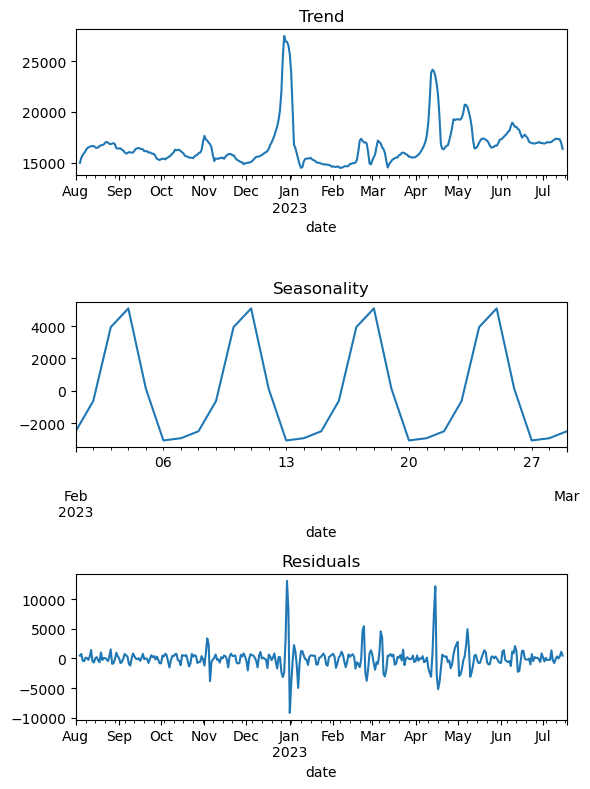

In [83]:
#Построим графики тренда,сезонности и остатков
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend') 

plt.subplot(312)
decomposed.seasonal['2023-02-01':'2023-03-01'].plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

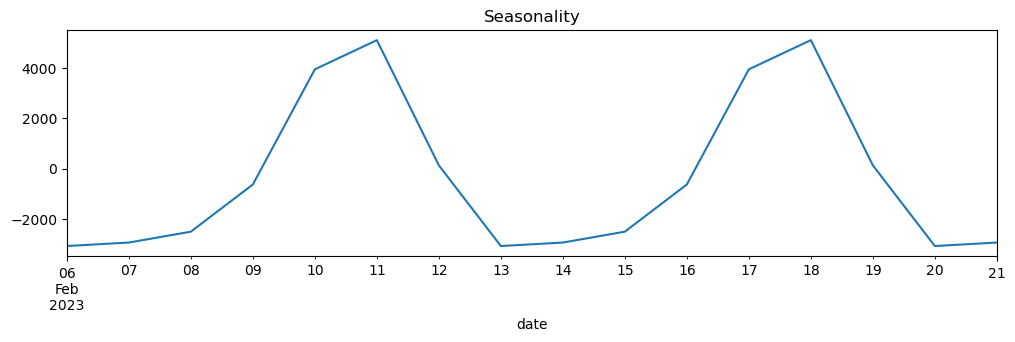

In [84]:
#Увеличим масштаб для изучения сезонности
plt.figure(figsize=(12, 10))

plt.subplot(312)
decomposed.seasonal['2023-02-06':'2023-02-21'].plot(ax=plt.gca()) 
plt.title('Seasonality');

Видна сезонность равная одной неделе. Эту информацию можно использовать при построении дополнительных признаков для модели.

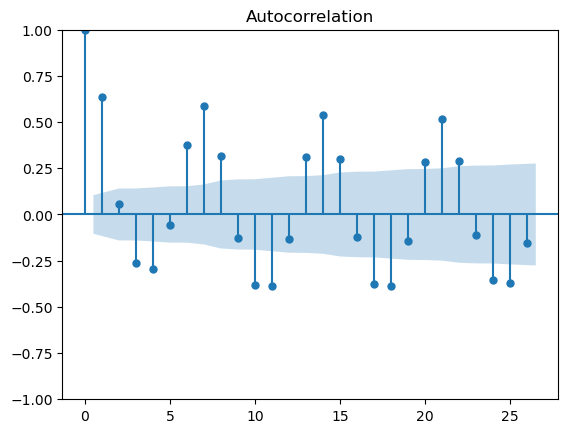

In [87]:
# Построим график автокорреляции
plot_acf(temp)
plt.show()

На графике автокорреляции видна связь корреляционных коэффициентов, которая помогает оценить значимые лаги. В целом график повторяет выводы по графику сезонности. 

#### Оценим стационарность временного ряда

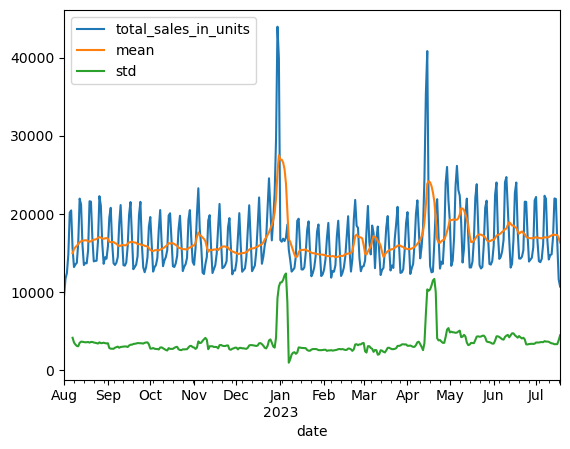

In [88]:
temp = pd.DataFrame(temp)
temp['mean'] = temp['total_sales_in_units'].rolling(7).mean() 
temp['std'] = temp['total_sales_in_units'].rolling(7).std()

temp.plot();

Попробуем оценить стационарность ряда при помощи критерия Дики-Фуллера:
    
    H0: Временной ряд является нестационарным,  
    H1: Временной ряд является стационарным. 
    Уровень значимости α = 0,05

In [89]:
#Рассчет критерия Дики-Фуллера
print(f"p_value = {round(adfuller(temp['total_sales_in_units'])[1], 2)}")

p_value = 0.0


При оценке стационарности временного ряда при помощи критерия Дики-Фуллера получено значение p_value = 0.01, получается мы можем отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.

Есть недельная сезонность - делаем признак день недели с тригонометрическим преобразованием
гиперпараметры max_lag, rolling_mean_size равными 7 (неделя).

#### 2.4 Анализ продаваемости товаров

Для анализа продаваемости будем использовать оригинальные данные, в которых не удалялись выбросы и не заполнялись пропущенные значения.

In [90]:
# Сделаем группировку по сумме продаж по месяцам и годам
temp = data.copy()
temp['month_year'] = temp['date'].apply(lambda x: x.strftime("%Y-%m"))
temp = temp.groupby('month_year')['total_sales_in_rub'].agg('sum')
temp = temp.reset_index()
temp.head()

,month_year,total_sales_in_rub
0,2022-08,45359571.0
1,2022-09,40786814.0
2,2022-10,40322750.0
3,2022-11,39618139.0
4,2022-12,58939700.0


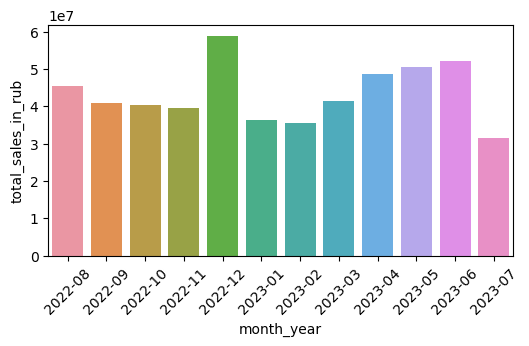

In [92]:
# Продажи по месяцам
figure, ax = plt.subplots()
figure.set_size_inches(6, 3)

sns.barplot(x = 'month_year', y = 'total_sales_in_rub', data = temp)
ax.tick_params(axis='x', labelrotation=45);

Ожидаемо максимальные продажи наблюдаются в декабре.Данные за июль 2023 не полные, поэтому видна сильная разница с июнем. Так как видны колебания продаж по месяцам - стоит добавить в данные признак соответствующий месяцу.

In [93]:
# Сгруппируем данные по группам товаром и оценим продажи
temp = data.groupby(['pr_group_id'], as_index = False).agg(
                        cat_count = ('pr_cat_id', 'nunique'),
                        subcat_count = ('pr_subcat_id', 'nunique'),
                        sku_count = ('pr_sku_id', 'nunique'), 
                        total_sales = ('total_sales_in_rub', 'sum'))
display(temp.sort_values('total_sales', ascending = False))

print(f"Суммарная выручка составляет {temp['total_sales'].sum()} руб.")

,pr_group_id,cat_count,subcat_count,sku_count,total_sales
5,aab3238922bcc25a6f606eb525ffdc56,9,44,695,160589981.0
3,6512bd43d9caa6e02c990b0a82652dca,6,14,199,131600301.0
8,c74d97b01eae257e44aa9d5bade97baf,10,54,740,98510610.0
7,c51ce410c124a10e0db5e4b97fc2af39,9,30,180,74037732.0
6,c20ad4d76fe97759aa27a0c99bff6710,2,9,72,41134610.0
1,32bb90e8976aab5298d5da10fe66f21d,3,5,27,12834193.0
0,1ff1de774005f8da13f42943881c655f,1,6,35,2539564.0
4,98f13708210194c475687be6106a3b84,2,2,4,67987.0
2,3c59dc048e8850243be8079a5c74d079,1,1,1,1661.0


Суммарная выручка составляет 521316639.0 руб.


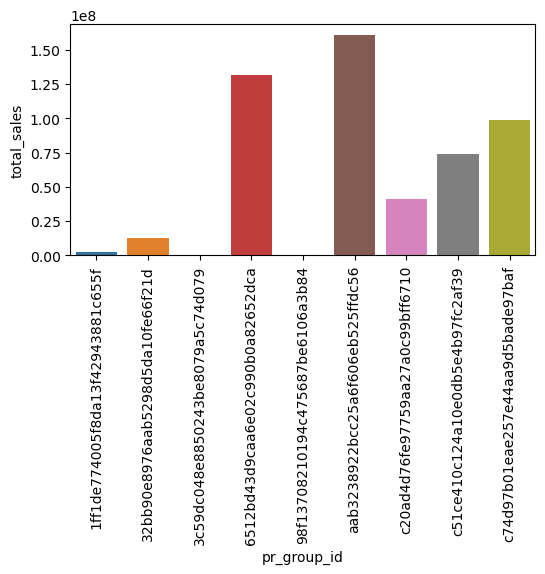

In [94]:
# Продажи по группам
figure, ax = plt.subplots()
figure.set_size_inches(6, 3)

sns.barplot(x = 'pr_group_id', y = 'total_sales', data = temp)
ax.tick_params(axis='x', labelrotation=90);

Видно, что самая продаваемая группа товаров - aab3238922bcc25a6f606eb525ffdc56 включает в себя 9 категорий и 44 подкатегории, а также 695 товаров. Это самое большое количество товаров из остальных групп, поэтому логично, что данная группа продается лучше остальных. Продажи около 160 млн. руб.

Вторая по продаваемости группа - 6512bd43d9caa6e02c990b0a82652dca отстает по выручке от первой на 18% но при этом в ней в три раза меньше товаров. Продажи 130 млн. руб.

Так же видны группы товаров в которые входит 1-4 товара, по ним продажи совсем небольшие - 1661 руб. и 67 987 руб. соответственно.

Корректное предсказание первых двух групп товаров дает нам 56% от общих продаж, первых трех групп - 75%, четырех - 89%, пяти - 97%

In [95]:
# Выделим топ-5 групп по продажам
top_groups = temp.sort_values('total_sales', ascending = False)['pr_group_id'].head()
top_groups

5    aab3238922bcc25a6f606eb525ffdc56
3    6512bd43d9caa6e02c990b0a82652dca
8    c74d97b01eae257e44aa9d5bade97baf
7    c51ce410c124a10e0db5e4b97fc2af39
6    c20ad4d76fe97759aa27a0c99bff6710
Name: pr_group_id, dtype: object

In [96]:
def add_features(data, feature):
    """Функция для создания дополнительных признаков для анализа:
    rank - нумерует категории внутри группы
    total_sales - сумма продаж по группе
    count_cat - общее количество категорий в группе
    sum_% - % продаж категории в группе
    cumsum_% - % коммулятивная сумма продаж по категориям
    cumulative_diff - % коммулятивная разница в приросте суммы продаж
    Возвращает датасет с новыми признаками.
    """
    data['rank'] = data.groupby('pr_group_id').cumcount() + 1
    for group in top_groups:
        sum_group = data.loc[data['pr_group_id'] == group, 'total_sales'].sum()
        data.loc[data['pr_group_id'] == group, 'count_cat'] = len(data.loc[data['pr_group_id'] == group, feature].unique())
        data.loc[data['pr_group_id'] == group, 'sum_%'] = data.loc[data['pr_group_id'] == group, 'total_sales'] / sum_group
        data.loc[data['pr_group_id'] == group, 'cumsum_%'] = data.loc[data['pr_group_id'] == group, 'sum_%'].cumsum()
        data.loc[data['pr_group_id'] == group, 'cumulative_diff'] = data.loc[data['pr_group_id'] == group, 'cumsum_%'].diff()
    return data

In [97]:
# Сгруппируем продажи по группе и категории
print(f" Количество уникальных категорий {data['pr_cat_id'].nunique()}")

temp = data.loc[data['pr_group_id'].isin(top_groups)]
temp = temp.groupby(['pr_group_id', 'pr_cat_id'], as_index = False).agg(
                        total_sales = ('total_sales_in_rub', 'sum')
                        )
# Отсортируем продажи внутри каждой группы по убыванию
temp = temp.sort_values(['pr_group_id', 'total_sales'], ascending = False)

# Добавим признаки для анализа - % продаж для каждой категории и разность в % между продажами
temp = add_features(temp, 'pr_cat_id')

# Выведем только те группы и категоии на которые приходятся основные продажи    
temp = temp.loc[(temp['cumulative_diff'] > 0.02)|(temp['cumulative_diff'].isna())]
print(f" Количество самых прибыльных категорий {len(temp['pr_cat_id'].unique())}")
temp

 Количество уникальных категорий 43
 Количество самых прибыльных категорий 20


,pr_group_id,pr_cat_id,total_sales,rank,count_cat,sum_%,cumsum_%,cumulative_diff
32,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,46762982.0,1,10.0,0.474700,0.474700,NaN
26,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,20238828.0,2,10.0,0.205448,0.680148,0.205448
34,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,19422182.0,3,10.0,0.197158,0.877306,0.197158
31,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,5508460.0,4,10.0,0.055917,0.933224,0.055917
35,c74d97b01eae257e44aa9d5bade97baf,faafda66202d234463057972460c04f5,2970284.0,5,10.0,0.030152,0.963376,0.030152
33,c74d97b01eae257e44aa9d5bade97baf,f18a6d1cde4b205199de8729a6637b42,2005710.0,6,10.0,0.020360,0.983736,0.020360
19,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,43632526.0,1,9.0,0.589328,0.589328,NaN
17,c51ce410c124a10e0db5e4b97fc2af39,2df45244f09369e16ea3f9117ca45157,16106693.0,2,9.0,0.217547,0.806875,0.217547
25,c51ce410c124a10e0db5e4b97fc2af39,fd5c905bcd8c3348ad1b35d7231ee2b1,7088399.0,3,9.0,0.095740,0.902616,0.095740
18,c51ce410c124a10e0db5e4b97fc2af39,535ab76633d94208236a2e829ea6d888,6638357.0,4,9.0,0.089662,0.992277,0.089662


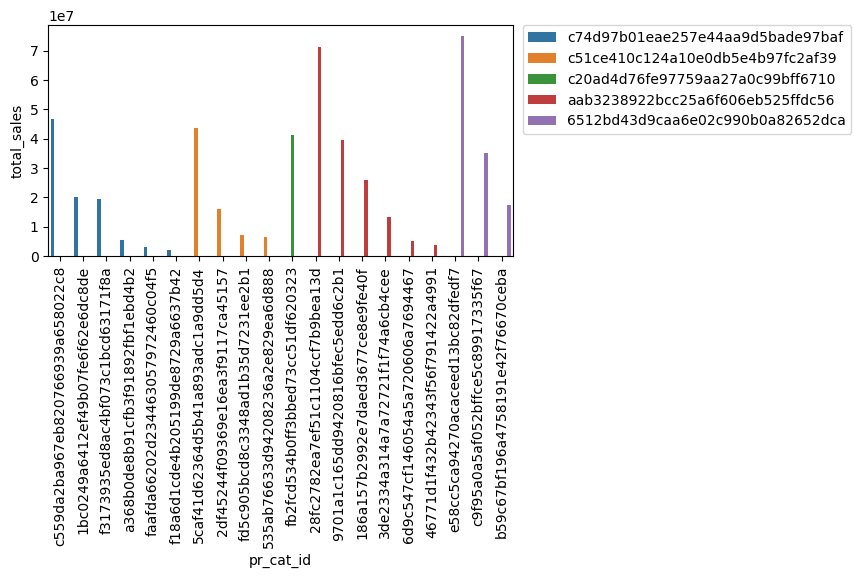

In [98]:
# Продажи по категориям
figure, ax = plt.subplots()
figure.set_size_inches(6, 3)

sns.barplot(x = 'pr_cat_id', y = 'total_sales', data = temp, hue = 'pr_group_id')
ax.tick_params(axis='x', labelrotation=90)
plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0 );

Внутри групп мы имеем 43 уникальные категории. Анализ продаж по категориям показывает, что для каждой группы основную долю продаж приносит только несколько категорий.

Например, в первой по продажам группе 10 категорий, из них первые пять обеспечивают 96% продаж. Для второй группы из 9 категорий первые 4 категории дают 99% продаж. 

In [99]:
# Выделим основные продаваемые категории по каждой группе
top_cats = temp['pr_cat_id'].unique()

cat_group_dict = {}
for group in top_groups:
    cats = temp.loc[temp['pr_group_id'] == group, 'pr_cat_id']
    cat_group_dict[group] = cats.to_list()

In [100]:
# Сгруппируем продажи по группе и категории и субкатегории
print(f" Количество уникальных субкатегорий {data['pr_subcat_id'].nunique()}")

temp = data.loc[(data['pr_group_id'].isin(top_groups))&(data['pr_cat_id'].isin(top_cats))]
temp = temp.groupby(['pr_group_id', 'pr_cat_id', 'pr_subcat_id'], as_index = False).agg(
                        total_sales = ('total_sales_in_rub', 'sum')
                        )

# Отсортируем продажи внутри каждой группы по убыванию
temp = temp.sort_values(['pr_group_id', 'total_sales'], ascending = False)

# Добавим признаки для анализа - % продаж для каждой субкатегории и разность в % между продажами
temp = add_features(temp, 'pr_subcat_id')
    
temp = temp.loc[(temp['cumulative_diff'] > 0.009)|(temp['cumulative_diff'].isna())]
print(f" Количество самых прибыльных субкатегорий {len(temp['pr_subcat_id'].unique())}")
temp.head(10)

 Количество уникальных субкатегорий 165
 Количество самых прибыльных субкатегорий 71


,pr_group_id,pr_cat_id,pr_subcat_id,total_sales,rank,count_cat,sum_%,cumsum_%,cumulative_diff
97,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,15108560.0,1,36.0,0.155906,0.155906,NaN
102,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,8221189.0,2,36.0,0.084835,0.240740,0.084835
90,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,34d2777e78ccf007523e2dd1fcea6b2d,5769688.0,3,36.0,0.059538,0.300278,0.059538
92,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,6e84696301885ba0a9dc8de6fe45abd0,5613416.0,4,36.0,0.057925,0.358203,0.057925
87,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,130d817d8b3f616e97c555ec57946aec,5442847.0,5,36.0,0.056165,0.414367,0.056165
101,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,4bc94de7bab27a1c3a9cd3ba68199f55,5225270.0,6,36.0,0.053920,0.468287,0.053920
105,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,bf7098fa7a7f267d4cd5a90f4b2cd8fa,4114563.0,7,36.0,0.042458,0.510745,0.042458
94,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,89b0107c6d0aca5f15fa7a715f9e06e5,4105681.0,8,36.0,0.042367,0.553112,0.042367
76,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,60787c41b04097dfea76addfccd12243,4074372.0,9,36.0,0.042044,0.595155,0.042044
78,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,3985317.0,10,36.0,0.041125,0.636280,0.041125


При анализе продаж по субкатегориям выявлена 71 уникальная субкатегория по которым продажи внутри каждой их групп максимальны.

ВЫВОДЫ ПО EDA
 - Нормализация данных

### 3. Modeling

In [105]:
def wape(target: pd.Series, predictions: pd.Series) -> float:
    '''Метрика WAPE для оценки моделей'''
    result = np.sum(np.abs(target - predictions)) / np.sum(np.abs(target))
    return result

wape_score = make_scorer(wape, greater_is_better=False)


def make_date_features(data: pd.DataFrame) -> pd.DataFrame:
    '''Функция для создания календарных признаков'''
    df = data.copy()
    # Добавим календарные признаки
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    # Кодируем день недели тригонометрическими функциями
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    return df

def filling_blanks(data: pd.DataFrame, shop: object, item: object, cat_columns):
    
    """Возвращает восстановленный временой ряд. Пропуски заполняются при помощи линейной интерполяции.
    Принимает на вход id магазина и товара."""
    # Срез по магазину и товару
    res = data.loc[(data['pr_sku_id'] == item) & (data['st_id'] == shop)]
    
    min_date = res['date'].min()
    max_date = res['date'].max()
    
    # Добавляем пропущенные даты
    res = res.set_index('date').reindex(pd.date_range(min_date, '2023-07-18', freq="1D"))
    
    # Заполняем категориальные столбцы
    for col in cat_columns:
        res[col] = res[col].unique()[0]
    
    # Заполняем пропуски
    res.loc[(res.index > max_date)&(res.index <= '2023-07-18'), 'total_sales_in_units'] = 0
    res['total_sales_in_units'].interpolate(method='time', inplace=True)
    
    return res

In [106]:
class Optimizer:
    def __init__(self, df: pd.DataFrame, model: any) -> None:
        self.df = df
        self.model = model
        self.exog_variables = []
        self.CAT_FEATURES = []
        self.NUM_FEATURES = []
    
    def tuning_preprocess(self) -> pd.DataFrame:
        '''Функция выполняет предобработку данных перед обучением моделей'''
        # Добавим экзогенные признаки
        df_extra = make_date_features(self.df)
        df_extra.reset_index(drop=True)

        # Выберем экзогенные признаки, категориальные и числовые
        self.exog_variables = ['day', 'month', 'day_of_week']
        self.CAT_FEATURES = list(df_extra.select_dtypes(include=["category", "object"]).columns)
        self.NUM_FEATURES = list(df_extra.select_dtypes(include=["number"]).columns)

        for feature in self.CAT_FEATURES:
            df_extra[feature] = df_extra[feature].astype('category')

        self.CAT_FEATURES.remove('pr_sku_id') # Этот признак подаётся в модели как параметр уникального id

        df_extra['ds'] = pd.to_datetime(df_extra['date'])
        df_extra['y'] = df_extra['total_sales_in_units']
        df_extra.drop(['date', 'total_sales_in_units'], axis=1, inplace=True)

        return df_extra


    def tuning_objective(self, trial) -> any:
        '''Функция осуществляет подбор гиперпараметров для модели'''
        df_extra = self.tuning_preprocess()
        
        # Параметры для настройки
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
        colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
        
        if self.model.__class__.__name__ == 'CatBoostRegressor':
            models = [self.model.set_params(random_state=RANDOM_STATE, n_estimators=500, learning_rate=learning_rate, 
                                                    max_depth=max_depth, subsample=subsample,
                                                    colsample_bylevel=colsample_bytree, cat_features=self.CAT_FEATURES)]
        elif self.model.__class__.__name__ == 'XGBRegressor':
            models = [self.model.set_params(random_state=RANDOM_STATE, n_estimators=500, learning_rate=learning_rate, max_depth=max_depth,
                           min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree, 
                           enable_categorical=True, tree_method='hist')]
        elif self.model.__class__.__name__ == 'LGBMRegressor':
            models = [self.model.set_params(random_state=RANDOM_STATE, n_estimators=500, learning_rate=learning_rate, 
                                                max_depth=max_depth, subsample=subsample,
                                                colsample_bytree=colsample_bytree)]

        lags = trial.suggest_int('lags', 14, 56, step=7) # step means we only try multiples of 7 starting from 14

        forecaster = MLForecast(models=models,
                        freq='D',
                        lags=[1,7, lags],
                        lag_transforms={
                        1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],
                    }, # removing this is better
                        #date_features=['dayofweek', 'month'],
                        num_threads=6)

        # Старт тестовой выборки
        test_dates = df_extra['ds'].max() - timedelta(days=test_days)
        
        # Получаем тренировочную выборку
        train_data = df_extra.loc[df_extra['ds'] <= test_dates]
        
        # Получаем тестовую выборку
        test_data = df_extra.loc[df_extra['ds'] > test_dates]

        forecaster.fit(train_data, id_col='unique_sku_id', time_col='ds', target_col='y', static_features=[])

        p = forecaster.predict(horizon=14, X_df=test_data.drop('y', axis=1))
        p = p.merge(test_data[['pr_sku_id', 'unique_sku_id', 'ds', 'y']], on=['unique_sku_id', 'ds'], how='left')

        error = mean_absolute_percentage_error(p['y'], p[self.model.__class__.__name__])

        return error

    def tuning_optimize(self) -> Tuple[float, dict]:
        study = optuna.create_study(direction='minimize')
        study.optimize(self.tuning_objective, n_trials=20)
        return study.best_value, study.best_params

In [107]:
class Predictor:
    def __init__(self, df: pd.DataFrame, future: pd.DataFrame, model: any) -> None:
        self.df = df
        self.future = future
        self.model = model
        print(self.df.shape)
        print(self.future.shape)

    def preprocess(self) -> pd.DataFrame:
        '''Функция выполняет предобработку данных перед обучением моделей'''
        # Добавим экзогенные признаки
        df_extra = make_date_features(self.df)
        future_extra = make_date_features(self.future)
        
        df_extra.reset_index(drop=True)
        future_extra.reset_index(drop=True)

        # Выберем экзогенные признаки, категориальные и числовые
        self.exog_variables = ['day', 'month', 'day_of_week']
        self.CAT_FEATURES = list(df_extra.select_dtypes(include=["category", "object"]).columns)
        self.NUM_FEATURES = list(df_extra.select_dtypes(include=["number"]).columns)

        for feature in self.CAT_FEATURES:
            df_extra[feature] = df_extra[feature].astype('category')
            future_extra[feature] = future_extra[feature].astype('category')

        self.CAT_FEATURES.remove('pr_sku_id') # Этот признак подаётся в модели как параметр уникального id

        df_extra['ds'] = pd.to_datetime(df_extra['date'])
        df_extra['y'] = df_extra['total_sales_in_units']
        df_extra.drop(['date', 'total_sales_in_units'], axis=1, inplace=True)

        future_extra['ds'] = pd.to_datetime(future_extra['date'])
        future_extra.drop(['date'], axis=1, inplace=True)

        return df_extra, future_extra
    
    def make_predictions(self) -> pd.DataFrame:

        df_extra, future_extra = self.preprocess()
        
        models = [self.model]
        
        forecaster = MLForecast(models=models,
                    freq='D',
                    lags=[49],
                    lag_transforms={
                        1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],
                    },
                    #date_features=['dayofweek', 'month'],
                    num_threads=6)

        forecaster.fit(df_extra, id_col='unique_sku_id', time_col='ds', target_col='y', static_features=[])

        p = forecaster.predict(horizon=14, X_df=future_extra)
        p = p.merge(future_extra[['st_id', 'pr_sku_id', 'ds', 'unique_sku_id']], on=['unique_sku_id', 'ds'], how='left')
        
        return p

#### 3.1 Загрузка и предобработка данных

In [108]:
# Данные о праздничных днях
holidays = pd.read_csv('data/holidays_covid_calendar.csv')
holidays = holidays[holidays['holiday'] == 1].copy()
holidays['date'] = pd.to_datetime(holidays['date'], format='%d.%m.%Y')

# Прочитаем файлы 
df = {}
for file in ['sales_df_train', 'pr_df', 'st_df', 'sales_submission']:
    df[file] = pd.read_csv(f'data/{file}.csv')

shops = df['sales_submission']['st_id'].unique()

# Удалим строки для которых число проданных товаров = 0, но при этом столбец продажа в руб отличается от 0
df['sales_df_train'] = df['sales_df_train'].loc[~((df['sales_df_train']['pr_sales_in_units'] == 0) & 
                                                  (df['sales_df_train']['pr_sales_in_rub'] != 0))]

# Переведем столбец date в формат даты
df['sales_df_train']['date'] = pd.to_datetime(df['sales_df_train']['date'], format='%Y-%m-%d')

# Удалим строки для которых продажи не равны 0, но продажи в штуках отсутствуют
df['sales_df_train'] = df['sales_df_train'].loc[~((df['sales_df_train']['pr_sales_in_rub'] == 0)&
                                                  (df['sales_df_train']['pr_sales_in_units'] != 0))]

# Оставляем для дальнейшего анализа только активные магазины и те, которые есть в sales_submission
df['sales_df_train'] = df['sales_df_train'].loc[df['sales_df_train']['st_id'].isin(shops)]

# Объединяем sales_df_train и st_df
data = df['sales_df_train'].merge(df['st_df'], how='left', on='st_id')
data.head()

# Объединяем data и pr_df
data = data.merge(df['pr_df'], how='left', on='pr_sku_id')
data.head()

# Сортируем по магазину, товару и по дате
data = data.sort_values(['st_id', 'pr_sku_id', 'date'])
data.head()

# Добавляем признаки общие продажи а штуках и рублях (промо + без промо)
data['total_sales_in_units'] = data.groupby(['st_id', 'pr_sku_id', 'date'])['pr_sales_in_units'].transform('sum')
data['total_sales_in_rub'] = data.groupby(['st_id', 'pr_sku_id', 'date'])['pr_sales_in_rub'].transform('sum')

# Добавляем признак праздничного дня
data['holiday'] = data['date'].isin(holidays['date']).astype(int)

# Удалим строки у которых total_sales_in_units = 0, а в рублях продажи есть
data = data.loc[~((data['total_sales_in_units'] == 0)&(data['total_sales_in_rub'] != 0))]

# Удаляем ненужные столбцы и получившиеся дубликаты
data = data.drop(['pr_sales_type_id', 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub',
                 'pr_promo_sales_in_rub', 'total_sales_in_rub', 'st_is_active'], axis = 1)
data = data.drop_duplicates()

# Изменим тип данных для определенных столбцов, так как они категориальные по своей сути
for col in ['st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_uom_id']:
    data[col] = data[col].astype('object')

#### Устранение пропусков

In [109]:
try:
    filled_df = pd.read_csv("data/filled_df.csv", parse_dates=['date'])
except IOError:

    # Создаем DataFrame с диапазоном дат
    dates = pd.date_range(start='2022-08-01', end='2023-07-18', freq='D')
    dates_df = pd.DataFrame({'date': dates})

    # Создаем пустой список для хранения заполненных данных
    filled_data = []

    # Создаём уникальный айди для каждого товара-магазина
    unique_sku_id = 0

    # Цикл для заполнения данных для каждого магазина и товара
    for store in data['st_id'].unique():
        for product in tqdm(data[data['st_id'] == store]['pr_sku_id'].unique()):
            # Получаем текущий фрагмент данных для конкретного магазина и товара
            subset = data[(data['st_id'] == store) & (data['pr_sku_id'] == product)]
            filling_row = subset.iloc[0]
            # Создаем временный DataFrame с диапазоном дат и объединяем его с текущим фрагментом данных
            temp_df = pd.merge(dates_df, subset, on='date', how='left')
            
            # Заполняем пропущенные значения категориальных столбцов одинаковыми значениями
            temp_df[['st_id', 'pr_sku_id', 'st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', \
                    'st_type_size_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id']] = \
                filling_row[['st_id', 'pr_sku_id', 'st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', \
                        'st_type_size_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id']]
            
            # Заполняем уникальный sku_id
            temp_df['unique_sku_id'] = unique_sku_id
            unique_sku_id += 1
            
            # Заполняем пропущенные значения total_sales_in_units нулем
            temp_df['total_sales_in_units'] = temp_df['total_sales_in_units'].fillna(0)
            
            # Заполняем пропущенные значения holiday на основе списка праздников
            temp_df['holiday'] = temp_df['date'].isin(holidays['date']).astype(int)
            
            # Добавляем заполненные данные в список
            filled_data.append(temp_df)
            
    # Объединяем все заполненные данные в один DataFrame
    filled_df = pd.concat(filled_data)

    # Сброс индекса
    filled_df.reset_index(drop=True, inplace=True)

    # Сохранение в файл
    filled_df.to_csv("data/filled_df.csv", index=False)

100%|██████████| 809/809 [00:54<00:00, 14.94it/s]


#### 3.2 Подбор гиперпараметров моделей бустингов

In [ ]:
# Оптимизация модели
model = xgb.XGBRegressor()
opt = Optimizer(filled_df,model)
metric, params = opt.tuning_optimize()

[I 2023-09-30 14:19:06,704] A new study created in memory with name: no-name-63867715-6120-4f21-85ae-167cd62e8f1b
[I 2023-09-30 14:22:27,237] Trial 0 finished with value: 2079490200030547.0 and parameters: {'learning_rate': 0.00502240153102858, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.45554665567261676, 'colsample_bytree': 0.9180093140602372, 'lags': 14}. Best is trial 0 with value: 2079490200030547.0.
[I 2023-09-30 14:23:32,472] Trial 1 finished with value: 1900566365080062.0 and parameters: {'learning_rate': 0.05735880073686668, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9939763637946293, 'colsample_bytree': 0.2555632561393951, 'lags': 56}. Best is trial 1 with value: 1900566365080062.0.
[I 2023-09-30 14:24:45,422] Trial 2 finished with value: 3259281603386106.0 and parameters: {'learning_rate': 0.002593645608244687, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.9211597142883916, 'colsample_bytree': 0.4503100561521567, 'lags': 35}. Best is trial 1 wit

In [ ]:
# Результаты оптимизации
print('Metric:', metric)
print('Params:', params)

Результаты подбора моделей на полном датасете


| Model | Metric | params |
|-------|--------|--------|
| XGBRegressor |  |  |
| CatBoostRegressor |  |  |
| LGBMRegressor |  |  |

#### 3.3 Получение предсказаний

In [12]:
predict_data = filled_df.copy()

In [13]:
''' 
Если были измененены признаки - добавлены или удалены и т.п., то нужно удалить файл future.csv, чтобы алгоритм создал его заново.
Также если вы добавите какие-нибудь признаки, зависящие от предыдущих данных, то нужно в этот алгоритм добавить их генерацию на 
будущих данных.
'''
try:
    future = pd.read_csv("data/future.csv")
except IOError:
    future = pd.DataFrame(columns=predict_data.columns)
    future_dates = ['2023-07-19', '2023-07-20', '2023-07-21', '2023-07-22', '2023-07-23',
                    '2023-07-24', '2023-07-25', '2023-07-26', '2023-07-27', '2023-07-28',
                    '2023-07-29', '2023-07-30', '2023-07-31', '2023-08-01']

    grouped_data = predict_data.groupby('st_id')

    for mag, group in grouped_data:
        sku_unique = group['pr_sku_id'].unique()
        for sku in tqdm(sku_unique):
            new_row = predict_data[(predict_data['st_id'] == mag) & (predict_data['pr_sku_id'] == sku)].iloc[0]
            for date in future_dates:
                new_row['date'] = pd.to_datetime(date)
                future.loc[len(future.index)] = new_row

    # Добавляем признак праздничного дня
    future['holiday'] = future['date'].isin(holidays['date']).astype(int)

    # Удалить целевую переменную
    future.drop('total_sales_in_units', axis=1, inplace=True)

    # Сохранить в файл
    future.to_csv("data/future.csv", index=False)

future['date'] = pd.to_datetime(future['date'], format='%Y-%m-%d')

100%|██████████| 809/809 [02:59<00:00,  4.50it/s]


In [18]:
CAT_FEATURES = list(predict_data.select_dtypes(include=["category", "object"]).columns)

model = cb.CatBoostRegressor(random_state=RANDOM_STATE, n_estimators=500, learning_rate=0.059571676265531955, 
                                                max_depth=10, subsample=0.7267250075830337,
                                                colsample_bylevel=0.10533753352857461, cat_features=CAT_FEATURES)
predictor = Predictor(predict_data, future, model)

(2125728, 15)
(84546, 14)


In [19]:
preds = predictor.make_predictions()

0:	learn: 9.4533148	total: 301ms	remaining: 2m 30s
1:	learn: 9.1494587	total: 527ms	remaining: 2m 11s
2:	learn: 8.8978905	total: 663ms	remaining: 1m 49s
3:	learn: 8.6689504	total: 927ms	remaining: 1m 54s
4:	learn: 8.5063632	total: 1.01s	remaining: 1m 39s
5:	learn: 8.3098845	total: 1.23s	remaining: 1m 41s
6:	learn: 8.1108204	total: 1.57s	remaining: 1m 50s
7:	learn: 7.9241073	total: 1.71s	remaining: 1m 44s
8:	learn: 7.7553972	total: 1.92s	remaining: 1m 44s
9:	learn: 7.6086027	total: 2.19s	remaining: 1m 47s
10:	learn: 7.4529669	total: 2.44s	remaining: 1m 48s
11:	learn: 7.3371570	total: 2.7s	remaining: 1m 49s
12:	learn: 7.2439235	total: 2.94s	remaining: 1m 50s
13:	learn: 7.2439232	total: 2.97s	remaining: 1m 43s
14:	learn: 7.1021076	total: 3.13s	remaining: 1m 41s
15:	learn: 7.0003215	total: 3.49s	remaining: 1m 45s
16:	learn: 6.9140466	total: 3.67s	remaining: 1m 44s
17:	learn: 6.7845979	total: 3.85s	remaining: 1m 43s
18:	learn: 6.6996839	total: 4.01s	remaining: 1m 41s
19:	learn: 6.6339902	to

In [20]:
preds

,unique_sku_id,ds,CatBoostRegressor,st_id,pr_sku_id
0,0,2023-07-19,0.440283,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3
1,0,2023-07-20,1.048020,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3
2,0,2023-07-21,2.828960,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3
3,0,2023-07-22,0.858841,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3
4,0,2023-07-23,0.821305,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3
...,...,...,...,...,...
84541,6038,2023-07-28,0.769124,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3
84542,6038,2023-07-29,0.370455,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3
84543,6038,2023-07-30,0.833698,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3
84544,6038,2023-07-31,0.471503,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3


**ВЫВОДЫ ОБЩИЕ**